In [1]:
#Import dependencies
from load_mnist import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

# Introduction

MNIST(Modified National Institute of Standards and Technology) is the classic dataset used for benchmarking classification algorithms. It is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60000x784 training set images, 60000x1 training set labels, 10000x784 testing set images and 10000x1 testing labels. The MNIST dataset can be accessed online from the website: http://yann.lecun.com/exdb/mnist/.

In this project, we will train the handwritten digits (0-9) classifier through Binary and Multi-class classification, followed by comparative analysis of the outcome of both the classifications.

### Load MNIST data

In [2]:
images_tr, labels_tr = load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')

5


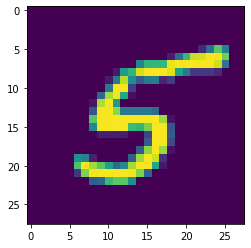

In [3]:
plt.imshow(np.reshape(images_tr[9783, :], (28, 28)))    # showing the image of the 9783 number
print(labels_tr[9783])                                  # printing the label of that image

In [4]:
print(images_tr.shape, labels_tr.shape)
print(images_tst.shape, labels_tst.shape)            # shape of matrix for images and labels

(60000, 784) (60000,)
(10000, 784) (10000,)


Each row contains 784 values (28x28 pixels image), which are the pixel values (a number from 0 to 255).
Because of this characteristic, the softmax function might overflow, we project [0, 255] to [0, 1] by dividing the dataset by 255.

In [5]:
X_train = images_tr/255                               #standardising data
X_test=images_tst/255
Y_train = labels_tr
Y_test = labels_tst

# One vs. Rest

We, firstly, used binary logistic regression to predict whether a label is 'n' or 'not n', where n = 0,1,...,9.
We have shown the example for n = 2.

In [6]:
Y_train_2 = (Y_train==2)  # 'True' when image or label is 2, otherwise 'False' (For training dataset)
Y_test_2 = (Y_test==2)    # 'True' when image or label is 2, otherwise 'False' (For testing dataset)

In [7]:
Y_train_2 = 1*Y_train_2   # converts True or False into 1 or 0
Y_test_2 = 1*Y_test_2

### Sigmoid function
We use sigmoid function to map predicted values to probabilities. This function maps any real value into another value between 0 and 1.
$$\sigma(z)=\frac{1}{1 + e^{-z}}$$

In [8]:
#Sigmoid function for binary logistic regression
def sigmoid(t):
    return 1/(1+np.exp(-t))
    raise NotImplementedError

### Negative log likelihood Loss function
Since our prediction function is non-linear in nature, it gives rise to a non-convex function with many local minimums if we use the conventional Mean Squared Error cost function. Therefore, we used Negative log likelihood Loss function which can be divided into two cost functions: one for y = 1 and one for y = 0. The loss function used is given below: 
The loss function used is given below:

\begin{align}
 h &= \sigma(tx\cdot w)\\
Cost(h,y)&=\frac{1}{m}\cdot[-y^{T}log(h-(1-y^{T})log(1-h)]\\
Cost(\sigma(tx\cdot w),y)&=\frac{1}{m}\cdot[-y^{T}log(\sigma(tx\cdot w))-(1-y^{T})log(1-\sigma(tx\cdot w))] \\
\end{align}

In [9]:
#Loss for binary logistic regression
def calculate_loss(y, tx, w):
    """
    y is labels (num_examples x 1)
    tx is the matrix of images with the first column vector of 1
    w is weights
    """
    # ***************************************************
    cost = -y.reshape(-1,1)*np.log(sigmoid(tx.dot(w))) - (1-y.reshape(-1,1))*np.log(1-sigmoid(tx.dot(w)))
    cost = cost.sum() / len(y)
    return cost
    # ***************************************************
    raise NotImplementedError

In [10]:
#Gradient for binary logistic regression
def calculate_gradient(y, tx, w):
    """
    y is labels (num_examples x 1)
    tx is the matrix of images with the first column vector of 1
    w is weights
    """
    # ***************************************************
    err = y.reshape(-1,1) - sigmoid(tx.dot(w))
    grad = -tx.T.dot(err) / len(err)
    return grad, err
    # ***************************************************
    raise NotImplementedError

### Performing Gradient Descent

We performed gradient descent to get weights.

In [11]:
def learning_by_gradient_descent(y, tx, w, tau):
    """
    Perform one step of gradient descent for logistic 
    regression. Return the loss and the updated w.
    """
    # ***************************************************
    loss = calculate_loss(y, tx, w)
    grad, err = calculate_gradient(y, tx, w)
    w = w - grad*tau
    # ***************************************************
    #raise NotImplementedError
    return loss, w

In [12]:
#Putting it all together for the binary logistic regression
from helpers import de_standardise
from tqdm import tqdm_notebook

def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 500
    threshold = 1e-4
    tau = 0.3
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in tqdm_notebook(range(max_iter)):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, tau)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualisation
    #visualisation(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    print("loss={l}".format(l=calculate_loss(y, tx, w)))
    return w

w_2 = logistic_regression_gradient_descent_demo(Y_train_2, X_train)

Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.10512816202766838
loss=0.09525357838237987


## Prediction 

After the gradient descent, we now have the weights (w). Therefore, we can find out the predicted y using the equation $\mathbf{Y=X^{T} \cdot  W}$.

In [13]:
tx_test_2 = np.c_[np.ones((Y_test_2.shape[0], 1)), X_test] # reshaping for matrix multiplication

In [14]:
#to find the predicted value of y
def predict(tx,w): 
    return tx.dot(w)

In [15]:
#applying Sigmoid function to the predicted value to get a probability distribution
Y_pred_2=sigmoid(predict(tx_test_2,w_2))

In [16]:
# decision boundary
Y_pred_2[Y_pred_2>0.5]=1
Y_pred_2[Y_pred_2<=0.5]=0

## Model Performance

In [17]:
def performance(y_true, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0                     # initialising

    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:       # true positive
           TP += 1
        if y_true[i] == 0 and y_pred[i] == 1:       # false positive
           FP += 1
        if y_true[i] == 0 and y_pred[i] == 0:       # true negative
           TN += 1
        if y_true[i] == 1 and y_pred[i] == 0:       # false negative
           FN += 1
        
        CF = np.arange(4).reshape(2,2)
        CF[0][0] = TN
        CF[0][1] = FP
        CF[1][0] = FN
        CF[1][1] = TP                               # confusion matrix
        accuracy = (TP+TN) / (TP+FP+TN+FN)    
    
    return CF, accuracy 

In [18]:
performance(Y_test_2, Y_pred_2)

(array([[8929,   39],
        [ 219,  813]]), 0.9742)

# Multi-class classification

### Softmax Activation

For multi-class classification, we use the Softmax function to link the linear inputs to probability distribution. So that we get a probability distribution with K class.<br>
In addition, to avoid overflowing and resulting in $nan$ we have chosen to subtract the maximum of x from x.

Softmax function: $$Softmax(z_{j})=\frac{e^{z_{j}}}{\sum_{k=1}^{n}e^{z_{k}}}$$

In [19]:
def softmax(x):
    x_shifted = x - x.max(axis=-1, keepdims=True)                  # subtrcating the maximum value to avoid overflow      
    return np.exp(x_shifted) / np.exp(x_shifted).sum(axis=1).reshape(len(x),1)

### Cross Entropy Loss

Cross entropy evaluates how close the original distribution and the actual distribution are.

Cross Entropy Loss function: $$H(y,p) = -\sum_{i}y_{i} log(p_{i})$$

In [20]:
def calculate_loss(y, tx, w):   
    """
    y is labels (num_examples x 1)
    tx is the matrix of images with the first column vector of 1
    w is weights
    """
    length = y.shape[0]
    soft_matrix = softmax(tx.dot(w))                          # softmax activation
    log_likelihood = -np.log(soft_matrix[range(length),y])    # softmax probability of the correct label
    loss = np.sum(log_likelihood) / length
    return loss

### Derivative of Softmax

\begin{align}
p_{j} &= \frac{e^{z_{j}}}{\sum_{k=1}^{n}e^{z_{k}}}\\
\frac{\partial p_{j}}{\partial z} &= \frac{\partial \frac{e^{z_{j}}}{\sum_{k} e^z_{j}} }{\partial z_{i}}\\
&=\frac{a \frac{\partial e^{z_{j}}}{\partial e^{z_{i}}} \cdot \sum_{k} e^{z_{k}} - e^{z_{i}} \cdot  e^{z_{j}}  }{ \left (\sum_{k} e^{z_{k}} \right ) ^{2}  }\\
&=\frac{ (e^{z_{j}})' }{\sum_{k} e^{z_{k}}  }- \frac{ e^{z_{i}}  }{\sum_{k} e^{z_{k}}} \cdot  \frac{e^{z_{j}} }{\sum_{k} e^{z_{k}}}
\end{align}

when i = j, $\frac{\partial e^{z_{j}}}{\partial e^{z_{i}}} = e^{z_{i}}$,
\begin{align}
\therefore \frac{\partial p_{j}}{\partial z_{i}} &= \frac{e^{z_j}}{\sum_{k} e^{z_{k}}} \left (1- \frac{e^{z_{j}}}{\sum_{k} e^{z_{k}}} \right )\\
&=p_{j} \left ( 1-p_{j} \right )
\end{align}

when i $\neq$ j, $\frac{\partial e^{z_{j}}}{\partial e^{z_{i}}} = 0$,
\begin{align}
\therefore \frac{\partial p_{j}}{\partial z_{i}} &= \frac{ 0\cdot \sum_{k} e^{z_{k}} -e^{z_{i}} \cdot e^{z_{j}} }{ \left ( \sum_{k} e^{z_{k}} \right )^{2}  }\\
&= -\frac{e^{z_{i}}}{ \sum_{k} e^{z_{k}}} \cdot  \frac{e^{z_{j}}}{ \sum_{k} e^{z_{k}}} \\
&= -p_{i} p_{j}
\end{align}

### Derivative of Cross Entropy Loss with Softmax

\begin{align}
L &= -\sum_{i}y_{i} \cdot log(p_{i})\\
\frac{\partial L}{\partial z_{i}} &= - \sum_{j} y_{j} \cdot \frac{\partial logp_{j}}{\partial z_{i}}\\
&=- \sum_{j} y_{j} \cdot \frac{1}{p_{j}} \cdot \frac{\partial p_{j}}{\partial z_{i}}\\
&=-y_{i} \cdot \frac{1}{p_{i}} \cdot p_{i} \left ( 1-p_{i} \right ) - \sum_{j\neq i} y_{j} \cdot \frac{1}{p_{j}} \cdot  \left ( -p_{j} p_{i} \right )\\
&= -y_{i} \cdot \left ( 1-p_{i} \right ) +  \sum_{j\neq i} y_{j} \cdot p_{i}\\
&= -y_{i} +y_{i} \cdot p_{i} +  \sum_{j\neq i} y_{j} \cdot p_{i}\\
&= p_{i} \cdot \sum_{j} y_{j} -y_{i}
\end{align}

By doing classification, there will be only one $y_{i}$ equals to 1.<br>
Therefore the above equation becomes:<br>
$$\frac{\partial L}{\partial z_{i}} = p_{i} - 1$$


By chain rule, we have: $$\frac{\partial Loss}{\partial w} = \frac{\partial Loss}{\partial z} \cdot  \frac{\partial z}{\partial w}$$ <br>
Since $$z=x \cdot w \Rightarrow \frac{\partial z}{\partial w} = x$$ <br>
We have $$\frac{\partial Loss}{\partial w} = (p_{i} -1) \cdot x$$

In [21]:
def calculate_gradient(y, tx, w):
    """
    y is labels (num_examples x 1)
    tx is the matrix of images with the first column vector of 1
    w is weights
    """
    length = y.shape[0]
    dz = softmax(tx.dot(w))
    dz[range(length),y] -= 1             # calculating dLoss/dz
    dz = dz/length
    dw=np.dot(tx.T, dz)                  # calculating dLoss/dw
    return dw

### Performing Gradient Descent

We performed gradient descent to get weights. Since the MNIST dataset is relatively large, we have added a progress bar.

In [22]:
def learning_by_gradient_descent(y, tx, w, tau):
    """
    Perform one step of gradient descent for logistic 
    regression. Return the loss and the updated w.
    """
    # ***************************************************
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    w = w - grad*tau                          # updating weights
    # ***************************************************
    #raise NotImplementedError
    return loss, w

In [23]:
from helpers import de_standardise
from tqdm import tqdm_notebook

def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 500
    threshold = 1e-4
    tau = 0.3
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # start the logistic regression
    for iter in tqdm_notebook(range(max_iter)):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, tau)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualisation
    #visualisation(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    print("loss={l}".format(l=calculate_loss(y, tx, w)))
    return w

w_lo = logistic_regression_gradient_descent_demo(Y_train, X_train)

Current iteration=0, loss=2.3025850929940455
Current iteration=100, loss=0.4397162761430162
Current iteration=200, loss=0.3792051798114966
Current iteration=300, loss=0.35293137155822624
Current iteration=400, loss=0.3372601364875879
loss=0.329178939049527


## Prediction

With the weights that we got from gradient descent and now with the equation $\mathbf{Y=tX \cdot  W}$, we can get a $m \times 10$ matrix $\mathbf{Y}$, where $m$ equals the number of rows in testing dataset and the index of each column means the probability that the predicted number is to be.

In [24]:
tx_test = np.c_[np.ones((labels_tst.shape[0], 1)), X_test]   # getting testing data
soft_test=softmax(tx_test.dot(w_lo))                         # using softmax to get a probability distribution
Y_pred = soft_test.argmax(axis=1)                            # locate the index with the maximum probability

## Model Performance

In [25]:
def performance(y_true, y_pred):
    y_actu = pd.Series(y_true, name='Actual')
    y_pred = pd.Series(y_pred, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)                            # confusion matrix
    accuracy = np.diag(df_confusion).sum() / df_confusion.values.sum()    # accuracy
    return df_confusion ,accuracy

In [26]:
performance(Y_test,Y_pred)

(Predicted    0     1    2    3    4    5    6    7    8    9
 Actual                                                      
 0          958     0    2    2    1    4    9    1    3    0
 1            0  1102    2    4    1    3    4    1   18    0
 2           11     7  901   15   16    1   15   18   40    8
 3            4     1   21  911    0   28    3   13   19   10
 4            1     3    6    1  915    0   10    1    8   37
 5           11     4    3   39   11  760   16   10   30    8
 6           14     3    4    3   12   13  906    1    2    0
 7            2    15   23    7    8    0    0  936    3   34
 8            8     9    7   26    8   23   13   14  854   12
 9           11     8    4   12   43    9    0   22    5  895, 0.9138)

The diagonal of confusion matrix equals the number of prediction that is same with the actual number. Accuracy equals sum of the numbers in diagonal over total number, which is 0.9138 here.

### Performing penalised gradient descent

For the penalised gradient descent we have performed it with different values of alpha and it turns out that smaller the alpha, higher the accuracy. Therefore, with the other parameters same as before, we have set alpha = 0.001.

In [26]:
def learning_by_penalised_gradient(y, tx, w, tau, alpha):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    # ***************************************************
    loss = calculate_loss(y, tx, w)
    loss =  loss + alpha * np.sum(w[:,1:]**2)       # adding the penalising term
    grad = calculate_gradient(y, tx, w)
    w = w - tau * grad
    w[:,1:] = w[:,1:] - tau*(alpha*w[:,1:])
    # ***************************************************
    #raise NotImplementedError
    return loss, w

In [27]:
def logistic_regression_penalised_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 500
    tau = 0.3
    alpha = 0.001
    threshold = 1e-4
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # start the logistic regression
    for iter in tqdm_notebook(range(max_iter)):
        # get loss and update w.
        loss, w = learning_by_penalised_gradient(y, tx, w, tau, alpha)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    #visualisation(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalised_gradient_descent")
    print("loss={l}".format(l=calculate_loss(y, tx, w)))
    return w
    
w_plo = logistic_regression_penalised_gradient_descent_demo(labels_tr, X_train)

Current iteration=0, loss=2.3025850929940455
Current iteration=100, loss=0.4655248783743917
Current iteration=200, loss=0.41691409946351227
Current iteration=300, loss=0.3989859321358719
loss=0.35257207399258184


### Prediction (penalised gradient descent)

In [28]:
soft_test=softmax(tx_test.dot(w_plo))
Y_pred = soft_test.argmax(axis=1)

### Model performance (penalised gradient descent)

In [29]:
performance(Y_test,Y_pred)

(Predicted    0     1    2    3    4    5    6    7    8    9
 Actual                                                      
 0          958     0    2    2    1    4    9    1    3    0
 1            0  1102    2    4    1    2    4    1   19    0
 2           11     8  897   15   15    1   16   19   42    8
 3            5     1   19  903    1   31    3   16   21   10
 4            1     4    5    1  911    1   11    1    8   39
 5           11     4    4   41   12  753   16   10   32    9
 6           15     3    5    2   13   16  901    1    2    0
 7            3    19   25    5   10    0    0  928    3   35
 8            9     9    9   26    8   21   14   15  849   14
 9           11     8    5   11   41   12    0   21    6  894, 0.9096)

<bk>
With penalised logistic regression, we get a lower accuracy. We guess it is because some of the loss was distributed to the penalised term.

## Comparison & Conclusion

The table given below shows the comparison between True-Positives produced by binary classifier and multi-classifier.

| Number(n) | Binary-class True Positive prediction | Multi-class True Positive prediction |
|-----------|---------------------------------------|--------------------------------------|
| 0         | 923                                   | 958                                  |
| 1         | 1057                                  | 1102                                 |
| 2         | 813                                   | 901                                  |
| 3         | 780                                   | 911                                  |
| 4         | 793                                   | 915                                  |
| 5         | 584                                   | 760                                  |
| 6         | 835                                   | 906                                  |
| 7         | 869                                   | 936                                  |
| 8         | 597                                   | 854                                  |
| 9         | 707                                   | 895                                  |

For all n, the number of true-positives produced by the multi-classifier is more than the number of True-positives produced by binary classifier. <br>
So we conclude that multi-class classification model turned out to be better at training the MNIST handwritten dataset.

# Weights visualisation

Since the weights that we calculated with the MNIST dataset could also be transformed to a $28\times 28$ matrix (excluding the weight for the 1's column), we could visualise the weights and see how it looks like.

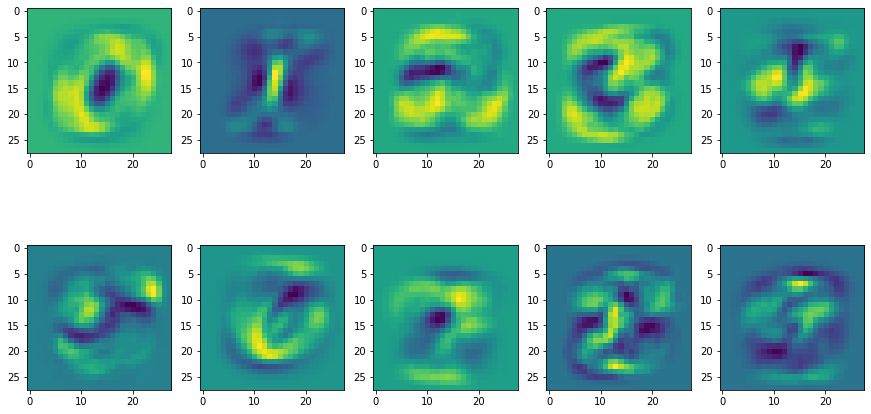

In [31]:
plt.figure(figsize=(15, 8))

plt.subplot(2,5,1)
WeightsToVisualize = 0
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,2)
WeightsToVisualize = 1
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,3)
WeightsToVisualize = 2
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,4)
WeightsToVisualize = 3
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,5)
WeightsToVisualize = 4
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))

plt.subplot(2,5,6)
WeightsToVisualize = 5
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,7)
WeightsToVisualize = 6
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,8)
WeightsToVisualize = 7
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,9)
WeightsToVisualize = 8
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))
plt.subplot(2,5,10)
WeightsToVisualize = 9
plt.imshow(np.reshape(w_lo[1:,WeightsToVisualize],(28,28)))


It is interesting that the visualisation of weights actually looks like the shape of the number they are responsible at classifying. 